<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Copy_of_phase01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image & Caption Classification

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import cv2
import warnings
import random

In [2]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

TRAIN_DATA_DIR = '/content/drive/MyDrive/dataset/train/images/'
TEST_DATA_DIR = '/content/drive/MyDrive/dataset/test/images/'
# TRAIN_DATA_DIR = './dataset/train/images/'
# TEST_DATA_DIR = './dataset/test/images'

TRAIN_DATA_SIZE = 532
TEST_DATA_SIZE = 380

NUMBER_OF_CLASSES = 19

IMG_WIDTH = 224
IMG_HEIGHT = 224

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

NUMBER_OF_CHANNELS = 3

LEARNING_RATE = 0.0001

EPOCHS = 10

In [4]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [5]:
CATEGORIES = list(label_map.values())

In [6]:
def prepare_data(DATA_DIR, CATEGORIES, img_width, img_height):
    data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return data

In [7]:
training_data = prepare_data(TRAIN_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [8]:
test_data = prepare_data(TEST_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [9]:
random.shuffle(training_data)
random.shuffle(test_data)

In [10]:
val_data_size = int(len(test_data) * 0.3)
val_data = test_data[:val_data_size]
test_data = test_data[val_data_size:]

In [11]:
print("the count of test samples: " + str(len(test_data)))
print("the count of validation samples: " + str(len(val_data)))

the count of test samples: 266
the count of validation samples: 114


In [12]:
X_train = []
y_train = []
for features, classes in training_data:
    X_train.append(features)
    y_train.append(classes)

X_train = np.array(X_train).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_train = np.array(y_train)
y_train_cat = tf.keras.utils.to_categorical(y_train)

In [13]:
X_val = []
y_val = []
for features, classes in val_data:
    X_val.append(features)
    y_val.append(classes)

X_val = np.array(X_val).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_val = np.array(y_val)
y_val_cat = tf.keras.utils.to_categorical(y_val)

In [14]:
X_test = []
y_test = []
for features, classes in test_data:
    X_test.append(features)
    y_test.append(classes)

X_test = np.array(X_test).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                  NUMBER_OF_CHANNELS)
y_test = np.array(y_test)

y_test_cat = tf.keras.utils.to_categorical(y_test)

In [15]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, 
                      v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [16]:
import imgaug as ia
import imgaug.augmenters as iaa
# from imgaug.augmenters import pillike

seq = iaa.Sequential([
        # iaa.Affine(rotate=(-20, 20)),
        
        # iaa.Affine(shear=(0,15)),
        
        # iaa.Fliplr(p=1.0), 
        
        # iaa.Affine(scale={"x": (1.15, 1.0), "y": (1.15, 1.0)}),
        iaa.GaussianBlur(sigma=(2, 2)),
        iaa.SaltAndPepper(0.05),
        iaa.Dropout(p=(0, 0.2)),
        # iaa.geometric.Rotate((-45, 45)),
        # iaa.TranslateX(px=(-40, 4)),
        # iaa.TranslateY(px=(-40, 40)),
        iaa.Fliplr(0.5),
        # iaa.ShearX((-30, 30)),
        # iaa.pillike.Equalize(),

        # iaa.Equalize(),
        
        
    ])

def augment(img):
    img = cv2.blur(img,(3,3))
    # eraser = get_random_eraser()
    # aug_image = eraser(img)
    # seq_det = seq.to_deterministic()
    # aug_image = seq_det.augment_image(img)
    return tf.keras.applications.densenet.preprocess_input(img)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    brightness_range=[0.2, 1.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # preprocessing_function=augment,
    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = ImageDataGenerator(rescale=1./255)

In [30]:
train_flow = train_generator.flow(
        X_train, 
        y_train_cat,
      )

# train_flow = train_generator.flow_from_directory(
#         TRAIN_DATA_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=TRAIN_BATCH_SIZE,
#         class_mode='categorical'
#       )

In [19]:
val_flow = test_generator.flow(
        X_val,
        y_val_cat,
      ) 

# test_flow = test_generator.flow_from_directory(
#         TEST_DATA_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=TEST_BATCH_SIZE,
#         class_mode='categorical'
#       ) 

In [20]:
test_flow = test_generator.flow(
        X_test,
        y_test_cat,
      ) 

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/DenseNet169.h5')

In [21]:
dense169 = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, NUMBER_OF_CHANNELS))

In [22]:
dense169.summary() # 595

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [23]:
model = Sequential()
model.add(dense169)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))

In [24]:
dense169.trainable = False

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_flow,
    # TRAIN_DATA_SIZE // TRAIN_BATCH_SIZE,
    epochs= 10,
    validation_data= test_flow,
    # validation_steps= TEST_DATA_SIZE // TEST_BATCH_SIZE
    )

Epoch 1/10
17/17 [==============================] - 165s 9s/step - loss: 2.9054 - accuracy: 0.0940 - val_loss: 2.7857 - val_accuracy: 0.2331
Epoch 2/10
17/17 [==============================] - 147s 9s/step - loss: 2.8399 - accuracy: 0.1278 - val_loss: 2.7119 - val_accuracy: 0.2970
Epoch 3/10
17/17 [==============================] - 151s 9s/step - loss: 2.7825 - accuracy: 0.1353 - val_loss: 2.6185 - val_accuracy: 0.3158
Epoch 4/10
17/17 [==============================] - 161s 10s/step - loss: 2.6989 - accuracy: 0.1654 - val_loss: 2.5104 - val_accuracy: 0.3684
Epoch 5/10
17/17 [==============================] - 159s 9s/step - loss: 2.5784 - accuracy: 0.2368 - val_loss: 2.3568 - val_accuracy: 0.3872
Epoch 6/10
17/17 [==============================] - 157s 9s/step - loss: 2.4895 - accuracy: 0.2556 - val_loss: 2.2217 - val_accuracy: 0.4135
Epoch 7/10
17/17 [==============================] - 159s 10s/step - loss: 2.3396 - accuracy: 0.3008 - val_loss: 2.0274 - val_accuracy: 0.4361
Epoch 8/10


In [32]:
dense169.trainable = True

set_trainable = False
for layer in dense169.layers:
    if layer.name == 'conv5_block32_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_flow,
    # TRAIN_DATA_SIZE // TRAIN_BATCH_SIZE,
    epochs= 10,
    validation_data= test_flow,
    # validation_steps= TEST_DATA_SIZE // TEST_BATCH_SIZE
    )

Epoch 1/10
17/17 [==============================] - 165s 9s/step - loss: 2.0814 - accuracy: 0.3571 - val_loss: 1.6697 - val_accuracy: 0.5376
Epoch 2/10
17/17 [==============================] - 156s 9s/step - loss: 1.9191 - accuracy: 0.4229 - val_loss: 1.5831 - val_accuracy: 0.5376
Epoch 3/10
17/17 [==============================] - 193s 12s/step - loss: 1.8423 - accuracy: 0.4154 - val_loss: 1.5222 - val_accuracy: 0.5602
Epoch 4/10
17/17 [==============================] - 169s 10s/step - loss: 1.7955 - accuracy: 0.4699 - val_loss: 1.4761 - val_accuracy: 0.5451
Epoch 5/10
17/17 [==============================] - 164s 10s/step - loss: 1.7021 - accuracy: 0.4944 - val_loss: 1.4552 - val_accuracy: 0.5451
Epoch 6/10
17/17 [==============================] - 165s 10s/step - loss: 1.6478 - accuracy: 0.4756 - val_loss: 1.3888 - val_accuracy: 0.5827
Epoch 7/10
17/17 [==============================] - 162s 10s/step - loss: 1.6330 - accuracy: 0.5188 - val_loss: 1.3990 - val_accuracy: 0.5789
Epoch 8/

In [ ]:
# for layer in dense169.layers:
#         if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
#             layer.trainable = True
#         else:
#             layer.trainable = False

Text(0.5, 1.0, 'Training and validation loss')

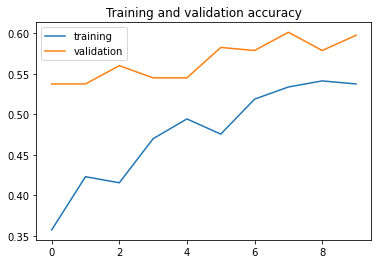

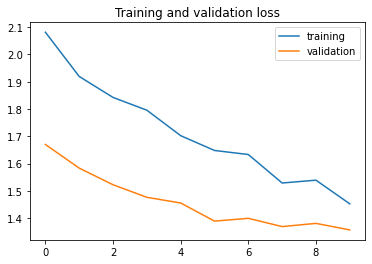

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [35]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print()

print('Classification Report')
print(classification_report(y_test, 
                            y_pred, 
                            target_names=CATEGORIES))

Confusion Matrix
[[ 0  0  0  0 12  0  0  0  0  2  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0  0  1  5]
 [ 2  0  0  1 11  0  0  0  0  0  0  0  0  0  2  0  1  1  0]
 [ 0  0  0  0  9  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  1  0  0  0  2]
 [ 1  0  0  0  7  1  0  0  0  0  0  0  2  0  2  0  0  0  1]
 [ 0  0  0  0  7  1  0  0  0  0  0  0  0  0  3  0  0  0  4]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  1  0  0  0  2]
 [ 0  0  1  0  5  0  0  0  0  1  0  0  0  0  5  0  1  0  2]
 [ 0  0  0  0  5  0  0  0  0  1  0  0  0  0  1  0  0  1  8]
 [ 0  0  0  0  5  0  1  0  0  0  0  0  0  0  2  0  0  0  2]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  1  0  6  0  0  2  3]
 [ 1  0  0  0  3  1  0  0  0  0  0  0  1  0  1  0  0  1  2]
 [ 0  0  0  0 10  1  0  0  0  0  0  0  0  0  3  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  4  0  1  1  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  2  0  4  0  0  0  0]
 [ 0  0  0  0  7  0  0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
loss_and_metrics = model.evaluate(test_flow, verbose=2)
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

9/9 - 53s - loss: 1.3565 - accuracy: 0.5977
Test Loss 1.3565113544464111
Test Accuracy 0.597744345664978
